<a href="https://colab.research.google.com/github/ranpei97/E4511-2021-Pei/blob/main/E4511-2021-Pei/Notebook/%20RF_Regression.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
%tensorflow_version 1.x

# get the Anaconda file 
! wget -c https://repo.anaconda.com/archive/Anaconda3-2019.10-Linux-x86_64.sh
! chmod +x Anaconda3-2019.10-Linux-x86_64.sh
! bash ./Anaconda3-2019.10-Linux-x86_64.sh -b -f -p /usr/local

! time conda install -y -c deepchem -c rdkit -c conda-forge -c omnia deepchem-gpu=2.3.0

import sys
sys.path.append('/usr/local/lib/python3.7/site-packages/')
import deepchem as dc

# install mordred, bravado and molvs
! time conda install -c conda-forge -y mordred bravado molvs

# get the Install AMPL_GPU_test.sh
!wget https://raw.githubusercontent.com/ravichas/AMPL-Tutorial/master/config/install_AMPL_GPU_test.sh

# run the script to install AMPL
! chmod u+x install_AMPL_GPU_test.sh
! ./install_AMPL_GPU_test.sh

!pip install hyperopt

# FutureWarnings and DeprecationWarnings are present from some of the AMPL 
# dependency modules.
import warnings
warnings.filterwarnings('ignore')

import json
# import numpy as np
# import pandas as pd
import os
import requests

import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
sns.set_context("poster")
sns.set_style("whitegrid")
sns.set_palette("Set2")

import pandas as pd
import os, json, sys, glob, pickle

TensorFlow 1.x selected.
--2021-05-06 09:33:15--  https://repo.anaconda.com/archive/Anaconda3-2019.10-Linux-x86_64.sh
Resolving repo.anaconda.com (repo.anaconda.com)... 104.16.130.3, 104.16.131.3, 2606:4700::6810:8303, ...
Connecting to repo.anaconda.com (repo.anaconda.com)|104.16.130.3|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 530308481 (506M) [application/x-sh]
Saving to: ‘Anaconda3-2019.10-Linux-x86_64.sh’

Anaconda3-2019.10-L 100%[===================>] 505.74M   211MB/s    in 2.4s    

2021-05-06 09:33:17 (211 MB/s) - ‘Anaconda3-2019.10-Linux-x86_64.sh’ saved [530308481/530308481]

PREFIX=/usr/local
Unpacking payload ...
Solving environment: | / - \ | / - \ | / - \ | / - \ | / - done

## Package Plan ##

  environment location: /usr/local

  added / updated specs:
    - _ipyw_jlab_nb_ext_conf==0.1.0=py37_0
    - _libgcc_mutex==0.1=main
    - alabaster==0.7.12=py37_0
    - anaconda-client==1.7.2=py37_0
    - anaco

/usr/local/lib/python3.7/dist-packages/sklearn/externals/joblib/__init__.py:15: FutureWarning: sklearn.externals.joblib is deprecated in 0.21 and will be removed in 0.23. Please import this functionality directly from joblib, which can be installed with: pip install joblib. If this warning is raised when loading pickled models, you may need to re-serialize those models with scikit-learn 0.21+.
  warnings.warn(msg, category=FutureWarning)


The TensorFlow contrib module will not be included in TensorFlow 2.0.
For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
  * https://github.com/tensorflow/io (for I/O related ops)
If you depend on functionality not listed there, please file an issue.

Solving environment: | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ done

## Package Plan ##

  environment location: /usr/local

  added / updated specs:
    - bravado
    - molvs
    - mordred


The following packages will be downloaded:

    package                    |            build
    ---------------------------|-----------------
    bravado-11.0.3             |     pyhd8ed1ab_0          31 KB  conda-forge
    brav

In [2]:
! pip install bravado

  Created wheel for strict-rfc3339: filename=strict_rfc3339-0.7-cp37-none-any.whl size=18120 sha256=4fc557e7305fbd27c4ea03099fa3adbc1223b271bcb63f5fbb79d79c60ba3a6d
  Stored in directory: /root/.cache/pip/wheels/bb/af/c9/b6e9fb5f9b2470e4ed2a7241c9ab3a8cdd3bc8555ae02ca2e6
Successfully built strict-rfc3339


In [3]:
# There is a problem with the previously imported cffi, so delete it and load it with AMPL instead
#if 'cffi' in sys.modules:
#  del sys.modules['cffi']
#import atomsci.ddm.pipeline.compare_models as cmp
from atomsci.ddm.pipeline import model_pipeline as mp
import atomsci.ddm.pipeline.compare_models as cmp
from atomsci.ddm.pipeline import parameter_parser as parse
from atomsci.ddm.pipeline import perf_data
from atomsci.ddm.pipeline import model_wrapper
from hyperopt import fmin, tpe, hp, Trials, STATUS_OK

In [4]:
! wget https://raw.githubusercontent.com/ranpei97/E4511-2021-Pei/main/HTR2A_cur.csv

--2021-05-06 09:41:48--  https://raw.githubusercontent.com/ranpei97/E4511-2021-Pei/main/HTR2A_cur.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.111.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 343123 (335K) [text/plain]
Saving to: ‘HTR2A_cur.csv’

HTR2A_cur.csv       100%[===================>] 335.08K  --.-KB/s    in 0.04s   

2021-05-06 09:41:48 (8.21 MB/s) - ‘HTR2A_cur.csv’ saved [343123/343123]



In [5]:
import pandas as pd
df = pd.read_csv('HTR2A_cur.csv', index_col=0)
df[df.compound_id.duplicated(keep=False)==True].sort_values(by='compound_id')
df_grouped = df.groupby('compound_id', as_index=False)['VALUE_NUM_mean'].mean()
df_dedup = df.drop_duplicates('compound_id')
df_avg = df_dedup.merge(df_grouped, left_on='compound_id', right_on='compound_id')
df_avg.drop('VALUE_NUM_mean_x', axis=1, inplace=True)
df_avg.rename(columns={'VALUE_NUM_mean_y': 'VALUE_NUM_mean'}, inplace=True)
df_avg

,index,compound_id,base_rdkit_smiles,relation,pXC50,active,VALUE_NUM_std,Perc_Var,mol_wt,VALUE_NUM_mean
0,497,CHEMBL4171368,CCC[C@@H](CCO)Nc1nc(N)nc2cc(OC)ccc12,NaN,5.749580,0,NaN,0.0,290.174276,5.749580
1,898,CHEMBL3600828,Clc1ccc(-c2ccc(C#Cc3ccc(OCCN4CCCC4)cc3)nc2)cc1,NaN,6.301030,0,0.0,0.0,402.149891,6.301030
2,872,CHEMBL178870,Nc1ccc(S(=O)(=O)n2cc(C3CCNCC3)c3ccc(Cl)cc32)cc1,NaN,6.270000,0,NaN,0.0,389.096476,6.270000
3,1459,CHEMBL74766,c1ccc2c(c1)Cc1ccccc1C21CCCNC1,NaN,7.000000,0,NaN,0.0,249.151750,7.000000
4,1038,44287208,Clc1cccc2cc3n(c12)CCNC3,NaN,6.481490,0,NaN,0.0,206.061076,6.481490
...,...,...,...,...,...,...,...,...,...,...
2857,1615,CHEMBL4209705,CCNC(=O)c1ccnc(OCCCCN2CCC(c3noc4cc(F)ccc34)CC2)c1,NaN,7.170696,1,NaN,0.0,440.222369,7.170696
2858,1421,CHEMBL187888,C[C@@H]1CNC[C@H]2Cc3ccc(C#N)cc3N12,NaN,6.960000,0,NaN,0.0,213.126597,6.960000
2859,463,CHEMBL1643858,CC(=O)N(C)c1ccc(OC2CN(c3c4c(nc5ccnn35)CCNCC4)C...,NaN,5.690000,0,NaN,0.0,406.211724,5.690000
2860,2442,66801028,O=S(=O)(NCCCN1CCC(c2noc3cc(F)ccc23)CC1)c1ccc(O...,NaN,8.420220,1,NaN,0.0,501.134540,8.420220


In [ ]:
df_avg.to_csv('DRD22_Merge_1.csv')

In [6]:
#Split

working_dir = '/content'

In [8]:

# data splits based on the scaffold of small molecules.
featurizer = 'ecfp' 
model_type = 'RF'
response_col = ['VALUE_NUM_mean']
smiles_col = 'base_rdkit_smiles'
compound_id = 'compound_id'
train_file = "HTR2A_cur.csv"
params = {
        "system": "LC",
        "lc_account": 'None',
        "datastore": "False",   #Boolean flag for using an input file from the LLNL specific datastore system based on a key of dataset_key
        "save_results": "False", # Save model results to MongoDB,
        "prediction_type": "regression",
        "dataset_key": train_file,
        "id_col": compound_id,
        "smiles_col": smiles_col,
        "response_cols": response_col,
        "previously_split": "False",  # Boolean flag for loading in previously split train, validation, and test csv files
        "split_only": "True",   # indicate splitting of the datasets when running the hyperparameter search
        'split_stategy':'train_valid_test',
        "featurizer": "ecfp",
        "model_type": "RF",
        "verbose": "True",
        "transformers": "True",
        'max_epochs': '70',
        "rerun": "False",
        "result_dir": working_dir
    }

ampl_param = parse.wrapper(params)
pl = mp.ModelPipeline(ampl_param)
pl.train_model()

2021-05-06 09:42:32,183 ['split_stategy'] are not part of the accepted list of parameters and will be ignored
2021-05-06 09:42:45,338 Splitting data by scaffold


number of features: 1024


2021-05-06 09:42:47,619 Dataset split table saved to /HTR2A_cur_train_valid_test_scaffold_a66f002a-67f4-4344-8590-98a7f72b0f14.csv


In [9]:
listing = glob.glob(os.path.join("/", "HTR2A_cur_train_valid_test_scaffold_a66f002a-67f4-4344-8590-98a7f72b0f14.csv"))

In [10]:
listing

['/HTR2A_cur_train_valid_test_scaffold_a66f002a-67f4-4344-8590-98a7f72b0f14.csv']

In [12]:
# train inital rf model
name = listing[0]
split_uuid = name.split("_")[-1].split(".")[0]
response_col = "VALUE_NUM_mean"
# default : rf_estimators=500, rf_max_features = 32
params = {
        "system": "LC",
        "lc_account": 'None',
        "datastore": "False",
        "save_results": "False",
        "data_owner": "username",
        "prediction_type": "regression",
        "dataset_key": train_file,
        "id_col": compound_id,
        "smiles_col": smiles_col,
        "response_cols": response_col,
        "split_uuid": split_uuid,   # UUID for csv file containing train, validation, and test split information
        "previously_split": "True",
        "featurizer": "ecfp",
        "model_type": "RF",
        "verbose": "True",
        "transformers": "True",
        'max_epochs': '70',
        "rerun": "False",
        "result_dir": "ampl_output"
    }

In [13]:
ampl_param = parse.wrapper(params)
pl = mp.ModelPipeline(ampl_param)
pl.train_model()

number of features: 1024


2021-05-06 09:43:30,462 Previous dataset split restored


TIMING: dataset construction took 0.128 s
Loading dataset from disk.
TIMING: dataset construction took 0.021 s
Loading dataset from disk.
TIMING: dataset construction took 0.022 s
Loading dataset from disk.


2021-05-06 09:43:40,583 Wrote model metadata to file ampl_output/HTR2A_cur/RF_ecfp_scaffold_regression/433d1de9-ec73-4ad2-9ae8-76a6486b4ad6/model_metadata.json
2021-05-06 09:43:41,697 Wrote model metrics to file ampl_output/HTR2A_cur/RF_ecfp_scaffold_regression/433d1de9-ec73-4ad2-9ae8-76a6486b4ad6/model_metrics.json


Wrote model tarball to ampl_output/HTR2A_cur_model_433d1de9-ec73-4ad2-9ae8-76a6486b4ad6.tar.gz


In [14]:

pred_data = pl.model_wrapper.get_perf_data(subset="valid", epoch_label="best")
pred_results = pred_data.get_prediction_results()
print(f"R2 score of validation set: {pred_results['r2_score']:.3f}")

R2 score of validation set: 0.497


In [15]:
pred_data = pl.model_wrapper.get_perf_data(subset="full", epoch_label="best")
pred_results = pred_data.get_prediction_results()
print(f"R2 score of test set: {pred_results['r2_score']:.3f}")

R2 score of test set: -30.057


In [16]:
# The glob module finds all the pathnames matching a specified pattern according to the rules
split_uuid = name.split("_")[-1].split(".")[0]
response_col = "VALUE_NUM_mean"

params = {
        "system": "LC",
        "lc_account": 'None',
        "datastore": "False",
        "save_results": "False",
        "data_owner": "username",
        "prediction_type": "regression",
        "dataset_key": train_file,
        "id_col": compound_id,
        "smiles_col": smiles_col,
        "response_cols": response_col,
        "split_uuid": split_uuid,
        "previously_split": "True",
        "featurizer": "ecfp",
        "model_type": "RF",       #Random forest
        "verbose": "True",
        "transformers": "True",
        'max_epochs': '70',      # Maximum number of training epochs to run for DNN models. Default 30.
        "rerun": "False",
        "result_dir": "ampl_output",
        "uncertainty": "True"  # Boolean flag for computing uncertainty estimates for regression model predictions. 
    }

In [17]:
ampl_param = parse.wrapper(params)
pl = mp.ModelPipeline(ampl_param)
pl.train_model()

number of features: 1024


2021-05-06 09:45:15,455 Previous dataset split restored


TIMING: dataset construction took 0.130 s
Loading dataset from disk.
TIMING: dataset construction took 0.024 s
Loading dataset from disk.
TIMING: dataset construction took 0.023 s
Loading dataset from disk.


2021-05-06 09:45:26,018 Wrote model metadata to file ampl_output/HTR2A_cur/RF_ecfp_scaffold_regression/a32bf3a1-80d9-499a-b9d8-7990e033a80d/model_metadata.json
2021-05-06 09:45:27,138 Wrote model metrics to file ampl_output/HTR2A_cur/RF_ecfp_scaffold_regression/a32bf3a1-80d9-499a-b9d8-7990e033a80d/model_metrics.json


Wrote model tarball to ampl_output/HTR2A_cur_model_a32bf3a1-80d9-499a-b9d8-7990e033a80d.tar.gz


In [18]:
pred_data = pl.model_wrapper.get_perf_data(subset="valid", epoch_label="best")
pred_results = pred_data.get_prediction_results()
print(f"R2 score of validation set: {pred_results['r2_score']:.3f}")

R2 score of validation set: 0.496


In [19]:
#GRIDE SEARCh

In [20]:
n_estimator = [150,300,400,500]
rf_max_depth = [15,70,150,250]
rf_max_features = [10,25,50,100]


rfe_list = []
rfd_list = []
rff_list = []
valid_r2_list = []
for rf_estimator in n_estimator:
    for rf_depth in rf_max_depth:
        for rf_feature in rf_max_features:
            params["rf_estimators"] = rf_estimator
            params["rf_max_depth"] = rf_depth
            params["rf_max_features"] = rf_feature
            rfe_list.append(rf_estimator)
            rfd_list.append(rf_depth)
            rff_list.append(rf_feature)
            tp = parse.wrapper(params)
            pl = mp.ModelPipeline(tp)
            pl.train_model()
            pred_data = pl.model_wrapper.get_perf_data(subset="valid", epoch_label="best")
            pred_results = pred_data.get_prediction_results()
            valid_r2 = pred_results['r2_score']
            valid_r2_list.append(valid_r2)
            print(f"rf_estimators: {rf_estimator}, rf_max_depth: {rf_depth}, rf_max_features: {rf_feature}, valid_r2: {valid_r2}")

number of features: 1024


2021-05-06 09:45:54,976 Previous dataset split restored


TIMING: dataset construction took 0.132 s
Loading dataset from disk.
TIMING: dataset construction took 0.022 s
Loading dataset from disk.
TIMING: dataset construction took 0.021 s
Loading dataset from disk.


2021-05-06 09:45:57,233 Wrote model metadata to file ampl_output/HTR2A_cur/RF_ecfp_scaffold_regression/5ea08805-d308-4a4f-a285-21031013082d/model_metadata.json
2021-05-06 09:45:57,334 Wrote model metrics to file ampl_output/HTR2A_cur/RF_ecfp_scaffold_regression/5ea08805-d308-4a4f-a285-21031013082d/model_metrics.json


Wrote model tarball to ampl_output/HTR2A_cur_model_5ea08805-d308-4a4f-a285-21031013082d.tar.gz
rf_estimators: 150, rf_max_depth: 15, rf_max_features: 10, valid_r2: 0.3740301930119829
number of features: 1024


2021-05-06 09:46:11,195 Previous dataset split restored


TIMING: dataset construction took 0.139 s
Loading dataset from disk.
TIMING: dataset construction took 0.023 s
Loading dataset from disk.
TIMING: dataset construction took 0.022 s
Loading dataset from disk.


2021-05-06 09:46:13,779 Wrote model metadata to file ampl_output/HTR2A_cur/RF_ecfp_scaffold_regression/2b172230-639a-4291-abd9-7ff2896b4e99/model_metadata.json
2021-05-06 09:46:13,895 Wrote model metrics to file ampl_output/HTR2A_cur/RF_ecfp_scaffold_regression/2b172230-639a-4291-abd9-7ff2896b4e99/model_metrics.json


Wrote model tarball to ampl_output/HTR2A_cur_model_2b172230-639a-4291-abd9-7ff2896b4e99.tar.gz
rf_estimators: 150, rf_max_depth: 15, rf_max_features: 25, valid_r2: 0.4123458560139678
number of features: 1024


2021-05-06 09:46:27,776 Previous dataset split restored


TIMING: dataset construction took 0.129 s
Loading dataset from disk.
TIMING: dataset construction took 0.021 s
Loading dataset from disk.
TIMING: dataset construction took 0.025 s
Loading dataset from disk.


2021-05-06 09:46:30,943 Wrote model metadata to file ampl_output/HTR2A_cur/RF_ecfp_scaffold_regression/31bcc971-cae4-4a51-b637-187f9c3093da/model_metadata.json
2021-05-06 09:46:31,061 Wrote model metrics to file ampl_output/HTR2A_cur/RF_ecfp_scaffold_regression/31bcc971-cae4-4a51-b637-187f9c3093da/model_metrics.json


Wrote model tarball to ampl_output/HTR2A_cur_model_31bcc971-cae4-4a51-b637-187f9c3093da.tar.gz
rf_estimators: 150, rf_max_depth: 15, rf_max_features: 50, valid_r2: 0.4378454313176279
number of features: 1024


2021-05-06 09:46:45,139 Previous dataset split restored


TIMING: dataset construction took 0.139 s
Loading dataset from disk.
TIMING: dataset construction took 0.022 s
Loading dataset from disk.
TIMING: dataset construction took 0.021 s
Loading dataset from disk.


2021-05-06 09:46:49,132 Wrote model metadata to file ampl_output/HTR2A_cur/RF_ecfp_scaffold_regression/6c91aa83-73d3-48d4-8ad3-dfbc17d3d888/model_metadata.json
2021-05-06 09:46:49,254 Wrote model metrics to file ampl_output/HTR2A_cur/RF_ecfp_scaffold_regression/6c91aa83-73d3-48d4-8ad3-dfbc17d3d888/model_metrics.json


Wrote model tarball to ampl_output/HTR2A_cur_model_6c91aa83-73d3-48d4-8ad3-dfbc17d3d888.tar.gz
rf_estimators: 150, rf_max_depth: 15, rf_max_features: 100, valid_r2: 0.44642983909096123
number of features: 1024


2021-05-06 09:47:03,328 Previous dataset split restored


TIMING: dataset construction took 0.132 s
Loading dataset from disk.
TIMING: dataset construction took 0.022 s
Loading dataset from disk.
TIMING: dataset construction took 0.022 s
Loading dataset from disk.


2021-05-06 09:47:06,645 Wrote model metadata to file ampl_output/HTR2A_cur/RF_ecfp_scaffold_regression/5b4d5f76-2fb0-44a5-9e5d-1d4d51a237ed/model_metadata.json
2021-05-06 09:47:06,985 Wrote model metrics to file ampl_output/HTR2A_cur/RF_ecfp_scaffold_regression/5b4d5f76-2fb0-44a5-9e5d-1d4d51a237ed/model_metrics.json


Wrote model tarball to ampl_output/HTR2A_cur_model_5b4d5f76-2fb0-44a5-9e5d-1d4d51a237ed.tar.gz
rf_estimators: 150, rf_max_depth: 70, rf_max_features: 10, valid_r2: 0.4843156325775452
number of features: 1024


2021-05-06 09:47:20,914 Previous dataset split restored


TIMING: dataset construction took 0.133 s
Loading dataset from disk.
TIMING: dataset construction took 0.024 s
Loading dataset from disk.
TIMING: dataset construction took 0.024 s
Loading dataset from disk.


2021-05-06 09:47:24,731 Wrote model metadata to file ampl_output/HTR2A_cur/RF_ecfp_scaffold_regression/f3947d40-34d8-4eb9-9a88-488c03b58790/model_metadata.json
2021-05-06 09:47:25,072 Wrote model metrics to file ampl_output/HTR2A_cur/RF_ecfp_scaffold_regression/f3947d40-34d8-4eb9-9a88-488c03b58790/model_metrics.json


Wrote model tarball to ampl_output/HTR2A_cur_model_f3947d40-34d8-4eb9-9a88-488c03b58790.tar.gz
rf_estimators: 150, rf_max_depth: 70, rf_max_features: 25, valid_r2: 0.49143365340324263
number of features: 1024


2021-05-06 09:47:38,980 Previous dataset split restored


TIMING: dataset construction took 0.133 s
Loading dataset from disk.
TIMING: dataset construction took 0.021 s
Loading dataset from disk.
TIMING: dataset construction took 0.022 s
Loading dataset from disk.


2021-05-06 09:47:43,423 Wrote model metadata to file ampl_output/HTR2A_cur/RF_ecfp_scaffold_regression/bbe28a06-236a-415b-b856-c0ec93f277af/model_metadata.json
2021-05-06 09:47:43,769 Wrote model metrics to file ampl_output/HTR2A_cur/RF_ecfp_scaffold_regression/bbe28a06-236a-415b-b856-c0ec93f277af/model_metrics.json


Wrote model tarball to ampl_output/HTR2A_cur_model_bbe28a06-236a-415b-b856-c0ec93f277af.tar.gz
rf_estimators: 150, rf_max_depth: 70, rf_max_features: 50, valid_r2: 0.4970426708561638
number of features: 1024


2021-05-06 09:47:57,765 Previous dataset split restored


TIMING: dataset construction took 0.135 s
Loading dataset from disk.
TIMING: dataset construction took 0.023 s
Loading dataset from disk.
TIMING: dataset construction took 0.022 s
Loading dataset from disk.


2021-05-06 09:48:03,606 Wrote model metadata to file ampl_output/HTR2A_cur/RF_ecfp_scaffold_regression/fd22a47c-aecd-4899-9965-ab9978af68d1/model_metadata.json
2021-05-06 09:48:03,972 Wrote model metrics to file ampl_output/HTR2A_cur/RF_ecfp_scaffold_regression/fd22a47c-aecd-4899-9965-ab9978af68d1/model_metrics.json


Wrote model tarball to ampl_output/HTR2A_cur_model_fd22a47c-aecd-4899-9965-ab9978af68d1.tar.gz
rf_estimators: 150, rf_max_depth: 70, rf_max_features: 100, valid_r2: 0.5143322869468414
number of features: 1024


2021-05-06 09:48:18,119 Previous dataset split restored


TIMING: dataset construction took 0.134 s
Loading dataset from disk.
TIMING: dataset construction took 0.025 s
Loading dataset from disk.
TIMING: dataset construction took 0.023 s
Loading dataset from disk.


2021-05-06 09:48:21,428 Wrote model metadata to file ampl_output/HTR2A_cur/RF_ecfp_scaffold_regression/d26e6d52-cff1-4ce9-ae05-ff4f88fc009b/model_metadata.json
2021-05-06 09:48:21,773 Wrote model metrics to file ampl_output/HTR2A_cur/RF_ecfp_scaffold_regression/d26e6d52-cff1-4ce9-ae05-ff4f88fc009b/model_metrics.json


Wrote model tarball to ampl_output/HTR2A_cur_model_d26e6d52-cff1-4ce9-ae05-ff4f88fc009b.tar.gz
rf_estimators: 150, rf_max_depth: 150, rf_max_features: 10, valid_r2: 0.48278085706024243
number of features: 1024


2021-05-06 09:48:35,669 Previous dataset split restored


TIMING: dataset construction took 0.129 s
Loading dataset from disk.
TIMING: dataset construction took 0.022 s
Loading dataset from disk.
TIMING: dataset construction took 0.024 s
Loading dataset from disk.


2021-05-06 09:48:39,406 Wrote model metadata to file ampl_output/HTR2A_cur/RF_ecfp_scaffold_regression/29b15d73-0235-4fdf-b63f-69f2d33e9e83/model_metadata.json
2021-05-06 09:48:39,764 Wrote model metrics to file ampl_output/HTR2A_cur/RF_ecfp_scaffold_regression/29b15d73-0235-4fdf-b63f-69f2d33e9e83/model_metrics.json


Wrote model tarball to ampl_output/HTR2A_cur_model_29b15d73-0235-4fdf-b63f-69f2d33e9e83.tar.gz
rf_estimators: 150, rf_max_depth: 150, rf_max_features: 25, valid_r2: 0.49985870948095135
number of features: 1024


2021-05-06 09:48:53,565 Previous dataset split restored


TIMING: dataset construction took 0.132 s
Loading dataset from disk.
TIMING: dataset construction took 0.022 s
Loading dataset from disk.
TIMING: dataset construction took 0.023 s
Loading dataset from disk.


2021-05-06 09:48:57,995 Wrote model metadata to file ampl_output/HTR2A_cur/RF_ecfp_scaffold_regression/049c3494-cc56-4b81-acbb-49e951594f48/model_metadata.json
2021-05-06 09:48:58,340 Wrote model metrics to file ampl_output/HTR2A_cur/RF_ecfp_scaffold_regression/049c3494-cc56-4b81-acbb-49e951594f48/model_metrics.json


Wrote model tarball to ampl_output/HTR2A_cur_model_049c3494-cc56-4b81-acbb-49e951594f48.tar.gz
rf_estimators: 150, rf_max_depth: 150, rf_max_features: 50, valid_r2: 0.5021711790401375
number of features: 1024


2021-05-06 09:49:12,351 Previous dataset split restored


TIMING: dataset construction took 0.135 s
Loading dataset from disk.
TIMING: dataset construction took 0.022 s
Loading dataset from disk.
TIMING: dataset construction took 0.021 s
Loading dataset from disk.


2021-05-06 09:49:18,067 Wrote model metadata to file ampl_output/HTR2A_cur/RF_ecfp_scaffold_regression/e09f896f-fcdc-405a-afa0-8e9abc972b4f/model_metadata.json
2021-05-06 09:49:18,406 Wrote model metrics to file ampl_output/HTR2A_cur/RF_ecfp_scaffold_regression/e09f896f-fcdc-405a-afa0-8e9abc972b4f/model_metrics.json


Wrote model tarball to ampl_output/HTR2A_cur_model_e09f896f-fcdc-405a-afa0-8e9abc972b4f.tar.gz
rf_estimators: 150, rf_max_depth: 150, rf_max_features: 100, valid_r2: 0.49941041174976897
number of features: 1024


2021-05-06 09:49:32,482 Previous dataset split restored


TIMING: dataset construction took 0.134 s
Loading dataset from disk.
TIMING: dataset construction took 0.023 s
Loading dataset from disk.
TIMING: dataset construction took 0.023 s
Loading dataset from disk.


2021-05-06 09:49:35,812 Wrote model metadata to file ampl_output/HTR2A_cur/RF_ecfp_scaffold_regression/c5b3e175-709c-40ee-8b30-68346b564fbf/model_metadata.json
2021-05-06 09:49:36,164 Wrote model metrics to file ampl_output/HTR2A_cur/RF_ecfp_scaffold_regression/c5b3e175-709c-40ee-8b30-68346b564fbf/model_metrics.json


Wrote model tarball to ampl_output/HTR2A_cur_model_c5b3e175-709c-40ee-8b30-68346b564fbf.tar.gz
rf_estimators: 150, rf_max_depth: 250, rf_max_features: 10, valid_r2: 0.4806135562325353
number of features: 1024


2021-05-06 09:49:50,238 Previous dataset split restored


TIMING: dataset construction took 0.137 s
Loading dataset from disk.
TIMING: dataset construction took 0.022 s
Loading dataset from disk.
TIMING: dataset construction took 0.022 s
Loading dataset from disk.


2021-05-06 09:49:54,055 Wrote model metadata to file ampl_output/HTR2A_cur/RF_ecfp_scaffold_regression/83fb6f4f-3632-4b20-8160-3b27fdbd2e45/model_metadata.json
2021-05-06 09:49:54,405 Wrote model metrics to file ampl_output/HTR2A_cur/RF_ecfp_scaffold_regression/83fb6f4f-3632-4b20-8160-3b27fdbd2e45/model_metrics.json


Wrote model tarball to ampl_output/HTR2A_cur_model_83fb6f4f-3632-4b20-8160-3b27fdbd2e45.tar.gz
rf_estimators: 150, rf_max_depth: 250, rf_max_features: 25, valid_r2: 0.4878909805175641
number of features: 1024


2021-05-06 09:50:08,522 Previous dataset split restored


TIMING: dataset construction took 0.134 s
Loading dataset from disk.
TIMING: dataset construction took 0.024 s
Loading dataset from disk.
TIMING: dataset construction took 0.023 s
Loading dataset from disk.


2021-05-06 09:50:13,006 Wrote model metadata to file ampl_output/HTR2A_cur/RF_ecfp_scaffold_regression/de0ff98c-150b-4224-b438-ae95d732ce67/model_metadata.json
2021-05-06 09:50:13,350 Wrote model metrics to file ampl_output/HTR2A_cur/RF_ecfp_scaffold_regression/de0ff98c-150b-4224-b438-ae95d732ce67/model_metrics.json


Wrote model tarball to ampl_output/HTR2A_cur_model_de0ff98c-150b-4224-b438-ae95d732ce67.tar.gz
rf_estimators: 150, rf_max_depth: 250, rf_max_features: 50, valid_r2: 0.49034157631661623
number of features: 1024


2021-05-06 09:50:27,480 Previous dataset split restored


TIMING: dataset construction took 0.146 s
Loading dataset from disk.
TIMING: dataset construction took 0.022 s
Loading dataset from disk.
TIMING: dataset construction took 0.022 s
Loading dataset from disk.


2021-05-06 09:50:33,223 Wrote model metadata to file ampl_output/HTR2A_cur/RF_ecfp_scaffold_regression/96e54684-e54a-427a-a559-f662aae432dc/model_metadata.json
2021-05-06 09:50:33,569 Wrote model metrics to file ampl_output/HTR2A_cur/RF_ecfp_scaffold_regression/96e54684-e54a-427a-a559-f662aae432dc/model_metrics.json


Wrote model tarball to ampl_output/HTR2A_cur_model_96e54684-e54a-427a-a559-f662aae432dc.tar.gz
rf_estimators: 150, rf_max_depth: 250, rf_max_features: 100, valid_r2: 0.49776131763132625
number of features: 1024


2021-05-06 09:50:47,629 Previous dataset split restored


TIMING: dataset construction took 0.134 s
Loading dataset from disk.
TIMING: dataset construction took 0.022 s
Loading dataset from disk.
TIMING: dataset construction took 0.022 s
Loading dataset from disk.


2021-05-06 09:50:50,968 Wrote model metadata to file ampl_output/HTR2A_cur/RF_ecfp_scaffold_regression/506ef6ab-97e9-42b6-8c1c-72c3e473131e/model_metadata.json
2021-05-06 09:50:51,160 Wrote model metrics to file ampl_output/HTR2A_cur/RF_ecfp_scaffold_regression/506ef6ab-97e9-42b6-8c1c-72c3e473131e/model_metrics.json


Wrote model tarball to ampl_output/HTR2A_cur_model_506ef6ab-97e9-42b6-8c1c-72c3e473131e.tar.gz
rf_estimators: 300, rf_max_depth: 15, rf_max_features: 10, valid_r2: 0.3701023857066099
number of features: 1024


2021-05-06 09:51:05,027 Previous dataset split restored


TIMING: dataset construction took 0.130 s
Loading dataset from disk.
TIMING: dataset construction took 0.022 s
Loading dataset from disk.
TIMING: dataset construction took 0.021 s
Loading dataset from disk.


2021-05-06 09:51:08,985 Wrote model metadata to file ampl_output/HTR2A_cur/RF_ecfp_scaffold_regression/05ba92a7-5005-4c8d-b242-f240591f1d79/model_metadata.json
2021-05-06 09:51:09,206 Wrote model metrics to file ampl_output/HTR2A_cur/RF_ecfp_scaffold_regression/05ba92a7-5005-4c8d-b242-f240591f1d79/model_metrics.json


Wrote model tarball to ampl_output/HTR2A_cur_model_05ba92a7-5005-4c8d-b242-f240591f1d79.tar.gz
rf_estimators: 300, rf_max_depth: 15, rf_max_features: 25, valid_r2: 0.41520963652863385
number of features: 1024


2021-05-06 09:51:23,246 Previous dataset split restored


TIMING: dataset construction took 0.132 s
Loading dataset from disk.
TIMING: dataset construction took 0.022 s
Loading dataset from disk.
TIMING: dataset construction took 0.024 s
Loading dataset from disk.


2021-05-06 09:51:28,133 Wrote model metadata to file ampl_output/HTR2A_cur/RF_ecfp_scaffold_regression/c57f9b79-35b9-4d71-984e-b170ef70561a/model_metadata.json
2021-05-06 09:51:28,369 Wrote model metrics to file ampl_output/HTR2A_cur/RF_ecfp_scaffold_regression/c57f9b79-35b9-4d71-984e-b170ef70561a/model_metrics.json


Wrote model tarball to ampl_output/HTR2A_cur_model_c57f9b79-35b9-4d71-984e-b170ef70561a.tar.gz
rf_estimators: 300, rf_max_depth: 15, rf_max_features: 50, valid_r2: 0.43426087093718657
number of features: 1024


2021-05-06 09:51:42,589 Previous dataset split restored


TIMING: dataset construction took 0.130 s
Loading dataset from disk.
TIMING: dataset construction took 0.022 s
Loading dataset from disk.
TIMING: dataset construction took 0.023 s
Loading dataset from disk.


2021-05-06 09:51:49,282 Wrote model metadata to file ampl_output/HTR2A_cur/RF_ecfp_scaffold_regression/21cc1d34-ec3a-4933-90e1-5cc536046b25/model_metadata.json
2021-05-06 09:51:49,528 Wrote model metrics to file ampl_output/HTR2A_cur/RF_ecfp_scaffold_regression/21cc1d34-ec3a-4933-90e1-5cc536046b25/model_metrics.json


Wrote model tarball to ampl_output/HTR2A_cur_model_21cc1d34-ec3a-4933-90e1-5cc536046b25.tar.gz
rf_estimators: 300, rf_max_depth: 15, rf_max_features: 100, valid_r2: 0.4468919081543289
number of features: 1024


2021-05-06 09:52:03,642 Previous dataset split restored


TIMING: dataset construction took 0.131 s
Loading dataset from disk.
TIMING: dataset construction took 0.025 s
Loading dataset from disk.
TIMING: dataset construction took 0.022 s
Loading dataset from disk.


2021-05-06 09:52:09,084 Wrote model metadata to file ampl_output/HTR2A_cur/RF_ecfp_scaffold_regression/5fa80da2-b58d-42d3-9d28-45be5ef83c69/model_metadata.json
2021-05-06 09:52:09,769 Wrote model metrics to file ampl_output/HTR2A_cur/RF_ecfp_scaffold_regression/5fa80da2-b58d-42d3-9d28-45be5ef83c69/model_metrics.json


Wrote model tarball to ampl_output/HTR2A_cur_model_5fa80da2-b58d-42d3-9d28-45be5ef83c69.tar.gz
rf_estimators: 300, rf_max_depth: 70, rf_max_features: 10, valid_r2: 0.47976503793752445
number of features: 1024


2021-05-06 09:52:23,843 Previous dataset split restored


TIMING: dataset construction took 0.139 s
Loading dataset from disk.
TIMING: dataset construction took 0.023 s
Loading dataset from disk.
TIMING: dataset construction took 0.023 s
Loading dataset from disk.


2021-05-06 09:52:30,180 Wrote model metadata to file ampl_output/HTR2A_cur/RF_ecfp_scaffold_regression/c89f95a3-2c84-43ae-9a17-9ac35ed7a662/model_metadata.json
2021-05-06 09:52:30,873 Wrote model metrics to file ampl_output/HTR2A_cur/RF_ecfp_scaffold_regression/c89f95a3-2c84-43ae-9a17-9ac35ed7a662/model_metrics.json


Wrote model tarball to ampl_output/HTR2A_cur_model_c89f95a3-2c84-43ae-9a17-9ac35ed7a662.tar.gz
rf_estimators: 300, rf_max_depth: 70, rf_max_features: 25, valid_r2: 0.4995217857634098
number of features: 1024


2021-05-06 09:52:45,028 Previous dataset split restored


TIMING: dataset construction took 0.128 s
Loading dataset from disk.
TIMING: dataset construction took 0.021 s
Loading dataset from disk.
TIMING: dataset construction took 0.022 s
Loading dataset from disk.


2021-05-06 09:52:52,560 Wrote model metadata to file ampl_output/HTR2A_cur/RF_ecfp_scaffold_regression/a4673ac1-9f04-486c-a549-34dc5b81b4f7/model_metadata.json
2021-05-06 09:52:53,252 Wrote model metrics to file ampl_output/HTR2A_cur/RF_ecfp_scaffold_regression/a4673ac1-9f04-486c-a549-34dc5b81b4f7/model_metrics.json


Wrote model tarball to ampl_output/HTR2A_cur_model_a4673ac1-9f04-486c-a549-34dc5b81b4f7.tar.gz
rf_estimators: 300, rf_max_depth: 70, rf_max_features: 50, valid_r2: 0.5054815375761184
number of features: 1024


2021-05-06 09:53:07,228 Previous dataset split restored


TIMING: dataset construction took 0.135 s
Loading dataset from disk.
TIMING: dataset construction took 0.023 s
Loading dataset from disk.
TIMING: dataset construction took 0.023 s
Loading dataset from disk.


2021-05-06 09:53:17,242 Wrote model metadata to file ampl_output/HTR2A_cur/RF_ecfp_scaffold_regression/b6bdf78d-271a-493e-b045-912d9db83ffb/model_metadata.json
2021-05-06 09:53:17,936 Wrote model metrics to file ampl_output/HTR2A_cur/RF_ecfp_scaffold_regression/b6bdf78d-271a-493e-b045-912d9db83ffb/model_metrics.json


Wrote model tarball to ampl_output/HTR2A_cur_model_b6bdf78d-271a-493e-b045-912d9db83ffb.tar.gz
rf_estimators: 300, rf_max_depth: 70, rf_max_features: 100, valid_r2: 0.5020543933709174
number of features: 1024


2021-05-06 09:53:31,847 Previous dataset split restored


TIMING: dataset construction took 0.131 s
Loading dataset from disk.
TIMING: dataset construction took 0.022 s
Loading dataset from disk.
TIMING: dataset construction took 0.022 s
Loading dataset from disk.


2021-05-06 09:53:37,306 Wrote model metadata to file ampl_output/HTR2A_cur/RF_ecfp_scaffold_regression/40ffeae3-10fb-4e28-ae88-f421d1e3b3ac/model_metadata.json
2021-05-06 09:53:38,023 Wrote model metrics to file ampl_output/HTR2A_cur/RF_ecfp_scaffold_regression/40ffeae3-10fb-4e28-ae88-f421d1e3b3ac/model_metrics.json


Wrote model tarball to ampl_output/HTR2A_cur_model_40ffeae3-10fb-4e28-ae88-f421d1e3b3ac.tar.gz
rf_estimators: 300, rf_max_depth: 150, rf_max_features: 10, valid_r2: 0.47522396482479623
number of features: 1024


2021-05-06 09:53:52,028 Previous dataset split restored


TIMING: dataset construction took 0.129 s
Loading dataset from disk.
TIMING: dataset construction took 0.022 s
Loading dataset from disk.
TIMING: dataset construction took 0.025 s
Loading dataset from disk.


2021-05-06 09:53:58,350 Wrote model metadata to file ampl_output/HTR2A_cur/RF_ecfp_scaffold_regression/e36e1bdc-0e36-4b2f-b005-d831005f3b56/model_metadata.json
2021-05-06 09:53:59,042 Wrote model metrics to file ampl_output/HTR2A_cur/RF_ecfp_scaffold_regression/e36e1bdc-0e36-4b2f-b005-d831005f3b56/model_metrics.json


Wrote model tarball to ampl_output/HTR2A_cur_model_e36e1bdc-0e36-4b2f-b005-d831005f3b56.tar.gz
rf_estimators: 300, rf_max_depth: 150, rf_max_features: 25, valid_r2: 0.49891041710550776
number of features: 1024


2021-05-06 09:54:13,191 Previous dataset split restored


TIMING: dataset construction took 0.136 s
Loading dataset from disk.
TIMING: dataset construction took 0.022 s
Loading dataset from disk.
TIMING: dataset construction took 0.023 s
Loading dataset from disk.


2021-05-06 09:54:20,959 Wrote model metadata to file ampl_output/HTR2A_cur/RF_ecfp_scaffold_regression/db2c7116-505c-4a99-8880-89ce24f4f186/model_metadata.json
2021-05-06 09:54:21,639 Wrote model metrics to file ampl_output/HTR2A_cur/RF_ecfp_scaffold_regression/db2c7116-505c-4a99-8880-89ce24f4f186/model_metrics.json


Wrote model tarball to ampl_output/HTR2A_cur_model_db2c7116-505c-4a99-8880-89ce24f4f186.tar.gz
rf_estimators: 300, rf_max_depth: 150, rf_max_features: 50, valid_r2: 0.5020198628796226
number of features: 1024


2021-05-06 09:54:35,680 Previous dataset split restored


TIMING: dataset construction took 0.134 s
Loading dataset from disk.
TIMING: dataset construction took 0.023 s
Loading dataset from disk.
TIMING: dataset construction took 0.022 s
Loading dataset from disk.


2021-05-06 09:54:45,906 Wrote model metadata to file ampl_output/HTR2A_cur/RF_ecfp_scaffold_regression/e0e88388-dbfd-4c27-a228-3ae182be8127/model_metadata.json
2021-05-06 09:54:46,575 Wrote model metrics to file ampl_output/HTR2A_cur/RF_ecfp_scaffold_regression/e0e88388-dbfd-4c27-a228-3ae182be8127/model_metrics.json


Wrote model tarball to ampl_output/HTR2A_cur_model_e0e88388-dbfd-4c27-a228-3ae182be8127.tar.gz
rf_estimators: 300, rf_max_depth: 150, rf_max_features: 100, valid_r2: 0.5011742405702284
number of features: 1024


2021-05-06 09:55:00,557 Previous dataset split restored


TIMING: dataset construction took 0.135 s
Loading dataset from disk.
TIMING: dataset construction took 0.021 s
Loading dataset from disk.
TIMING: dataset construction took 0.025 s
Loading dataset from disk.


2021-05-06 09:55:06,004 Wrote model metadata to file ampl_output/HTR2A_cur/RF_ecfp_scaffold_regression/94c5c4a8-fb6c-426c-8f8c-cfc5c299597b/model_metadata.json
2021-05-06 09:55:06,679 Wrote model metrics to file ampl_output/HTR2A_cur/RF_ecfp_scaffold_regression/94c5c4a8-fb6c-426c-8f8c-cfc5c299597b/model_metrics.json


Wrote model tarball to ampl_output/HTR2A_cur_model_94c5c4a8-fb6c-426c-8f8c-cfc5c299597b.tar.gz
rf_estimators: 300, rf_max_depth: 250, rf_max_features: 10, valid_r2: 0.4889343007063124
number of features: 1024


2021-05-06 09:55:20,596 Previous dataset split restored


TIMING: dataset construction took 0.136 s
Loading dataset from disk.
TIMING: dataset construction took 0.022 s
Loading dataset from disk.
TIMING: dataset construction took 0.022 s
Loading dataset from disk.


2021-05-06 09:55:26,959 Wrote model metadata to file ampl_output/HTR2A_cur/RF_ecfp_scaffold_regression/802056c6-bdaf-421c-ad5d-4cdac76b8456/model_metadata.json
2021-05-06 09:55:27,652 Wrote model metrics to file ampl_output/HTR2A_cur/RF_ecfp_scaffold_regression/802056c6-bdaf-421c-ad5d-4cdac76b8456/model_metrics.json


Wrote model tarball to ampl_output/HTR2A_cur_model_802056c6-bdaf-421c-ad5d-4cdac76b8456.tar.gz
rf_estimators: 300, rf_max_depth: 250, rf_max_features: 25, valid_r2: 0.5021268573753614
number of features: 1024


2021-05-06 09:55:41,660 Previous dataset split restored


TIMING: dataset construction took 0.142 s
Loading dataset from disk.
TIMING: dataset construction took 0.022 s
Loading dataset from disk.
TIMING: dataset construction took 0.023 s
Loading dataset from disk.


2021-05-06 09:55:49,188 Wrote model metadata to file ampl_output/HTR2A_cur/RF_ecfp_scaffold_regression/2fda57a6-3096-4ff1-bf2a-50b3a629852e/model_metadata.json
2021-05-06 09:55:49,877 Wrote model metrics to file ampl_output/HTR2A_cur/RF_ecfp_scaffold_regression/2fda57a6-3096-4ff1-bf2a-50b3a629852e/model_metrics.json


Wrote model tarball to ampl_output/HTR2A_cur_model_2fda57a6-3096-4ff1-bf2a-50b3a629852e.tar.gz
rf_estimators: 300, rf_max_depth: 250, rf_max_features: 50, valid_r2: 0.5045289269229236
number of features: 1024


2021-05-06 09:56:03,893 Previous dataset split restored


TIMING: dataset construction took 0.132 s
Loading dataset from disk.
TIMING: dataset construction took 0.023 s
Loading dataset from disk.
TIMING: dataset construction took 0.022 s
Loading dataset from disk.


2021-05-06 09:56:14,246 Wrote model metadata to file ampl_output/HTR2A_cur/RF_ecfp_scaffold_regression/52b57281-4008-413b-b1d9-44561b651596/model_metadata.json
2021-05-06 09:56:14,909 Wrote model metrics to file ampl_output/HTR2A_cur/RF_ecfp_scaffold_regression/52b57281-4008-413b-b1d9-44561b651596/model_metrics.json


Wrote model tarball to ampl_output/HTR2A_cur_model_52b57281-4008-413b-b1d9-44561b651596.tar.gz
rf_estimators: 300, rf_max_depth: 250, rf_max_features: 100, valid_r2: 0.5031613868563191
number of features: 1024


2021-05-06 09:56:28,919 Previous dataset split restored


TIMING: dataset construction took 0.145 s
Loading dataset from disk.
TIMING: dataset construction took 0.022 s
Loading dataset from disk.
TIMING: dataset construction took 0.022 s
Loading dataset from disk.


2021-05-06 09:56:32,829 Wrote model metadata to file ampl_output/HTR2A_cur/RF_ecfp_scaffold_regression/6059c1eb-6bde-4149-b992-a40ee9bc222f/model_metadata.json
2021-05-06 09:56:33,090 Wrote model metrics to file ampl_output/HTR2A_cur/RF_ecfp_scaffold_regression/6059c1eb-6bde-4149-b992-a40ee9bc222f/model_metrics.json


Wrote model tarball to ampl_output/HTR2A_cur_model_6059c1eb-6bde-4149-b992-a40ee9bc222f.tar.gz
rf_estimators: 400, rf_max_depth: 15, rf_max_features: 10, valid_r2: 0.37397122949302974
number of features: 1024


2021-05-06 09:56:47,100 Previous dataset split restored


TIMING: dataset construction took 0.132 s
Loading dataset from disk.
TIMING: dataset construction took 0.023 s
Loading dataset from disk.
TIMING: dataset construction took 0.026 s
Loading dataset from disk.


2021-05-06 09:56:51,938 Wrote model metadata to file ampl_output/HTR2A_cur/RF_ecfp_scaffold_regression/be9b671d-62a9-4be4-8dd6-258c4bb3edfb/model_metadata.json
2021-05-06 09:56:52,232 Wrote model metrics to file ampl_output/HTR2A_cur/RF_ecfp_scaffold_regression/be9b671d-62a9-4be4-8dd6-258c4bb3edfb/model_metrics.json


Wrote model tarball to ampl_output/HTR2A_cur_model_be9b671d-62a9-4be4-8dd6-258c4bb3edfb.tar.gz
rf_estimators: 400, rf_max_depth: 15, rf_max_features: 25, valid_r2: 0.417951693065434
number of features: 1024


2021-05-06 09:57:06,227 Previous dataset split restored


TIMING: dataset construction took 0.133 s
Loading dataset from disk.
TIMING: dataset construction took 0.022 s
Loading dataset from disk.
TIMING: dataset construction took 0.023 s
Loading dataset from disk.


2021-05-06 09:57:12,548 Wrote model metadata to file ampl_output/HTR2A_cur/RF_ecfp_scaffold_regression/f9890faf-e912-445c-8b6f-e75a0c1601c0/model_metadata.json
2021-05-06 09:57:12,858 Wrote model metrics to file ampl_output/HTR2A_cur/RF_ecfp_scaffold_regression/f9890faf-e912-445c-8b6f-e75a0c1601c0/model_metrics.json


Wrote model tarball to ampl_output/HTR2A_cur_model_f9890faf-e912-445c-8b6f-e75a0c1601c0.tar.gz
rf_estimators: 400, rf_max_depth: 15, rf_max_features: 50, valid_r2: 0.4391991549561921
number of features: 1024


2021-05-06 09:57:26,873 Previous dataset split restored


TIMING: dataset construction took 0.135 s
Loading dataset from disk.
TIMING: dataset construction took 0.022 s
Loading dataset from disk.
TIMING: dataset construction took 0.026 s
Loading dataset from disk.


2021-05-06 09:57:35,682 Wrote model metadata to file ampl_output/HTR2A_cur/RF_ecfp_scaffold_regression/1ee1d6e4-4177-43af-95a8-0d7ad85b8df8/model_metadata.json
2021-05-06 09:57:35,990 Wrote model metrics to file ampl_output/HTR2A_cur/RF_ecfp_scaffold_regression/1ee1d6e4-4177-43af-95a8-0d7ad85b8df8/model_metrics.json


Wrote model tarball to ampl_output/HTR2A_cur_model_1ee1d6e4-4177-43af-95a8-0d7ad85b8df8.tar.gz
rf_estimators: 400, rf_max_depth: 15, rf_max_features: 100, valid_r2: 0.4539953112689791
number of features: 1024


2021-05-06 09:57:49,996 Previous dataset split restored


TIMING: dataset construction took 0.133 s
Loading dataset from disk.
TIMING: dataset construction took 0.024 s
Loading dataset from disk.
TIMING: dataset construction took 0.026 s
Loading dataset from disk.


2021-05-06 09:57:57,043 Wrote model metadata to file ampl_output/HTR2A_cur/RF_ecfp_scaffold_regression/8fbdfbfd-8c0e-4602-abef-20adf6dda885/model_metadata.json
2021-05-06 09:57:57,952 Wrote model metrics to file ampl_output/HTR2A_cur/RF_ecfp_scaffold_regression/8fbdfbfd-8c0e-4602-abef-20adf6dda885/model_metrics.json


Wrote model tarball to ampl_output/HTR2A_cur_model_8fbdfbfd-8c0e-4602-abef-20adf6dda885.tar.gz
rf_estimators: 400, rf_max_depth: 70, rf_max_features: 10, valid_r2: 0.48329553233151545
number of features: 1024


2021-05-06 09:58:11,930 Previous dataset split restored


TIMING: dataset construction took 0.128 s
Loading dataset from disk.
TIMING: dataset construction took 0.022 s
Loading dataset from disk.
TIMING: dataset construction took 0.022 s
Loading dataset from disk.


2021-05-06 09:58:19,820 Wrote model metadata to file ampl_output/HTR2A_cur/RF_ecfp_scaffold_regression/0a162981-2d94-4cc4-a31b-e1b71ae9cd54/model_metadata.json
2021-05-06 09:58:20,720 Wrote model metrics to file ampl_output/HTR2A_cur/RF_ecfp_scaffold_regression/0a162981-2d94-4cc4-a31b-e1b71ae9cd54/model_metrics.json


Wrote model tarball to ampl_output/HTR2A_cur_model_0a162981-2d94-4cc4-a31b-e1b71ae9cd54.tar.gz
rf_estimators: 400, rf_max_depth: 70, rf_max_features: 25, valid_r2: 0.4978779244855146
number of features: 1024


2021-05-06 09:58:34,533 Previous dataset split restored


TIMING: dataset construction took 0.126 s
Loading dataset from disk.
TIMING: dataset construction took 0.022 s
Loading dataset from disk.
TIMING: dataset construction took 0.021 s
Loading dataset from disk.


2021-05-06 09:58:44,152 Wrote model metadata to file ampl_output/HTR2A_cur/RF_ecfp_scaffold_regression/879428ca-2480-40b9-a093-1c739d983dab/model_metadata.json
2021-05-06 09:58:45,029 Wrote model metrics to file ampl_output/HTR2A_cur/RF_ecfp_scaffold_regression/879428ca-2480-40b9-a093-1c739d983dab/model_metrics.json


Wrote model tarball to ampl_output/HTR2A_cur_model_879428ca-2480-40b9-a093-1c739d983dab.tar.gz
rf_estimators: 400, rf_max_depth: 70, rf_max_features: 50, valid_r2: 0.5023660858586461
number of features: 1024


2021-05-06 09:58:58,877 Previous dataset split restored


TIMING: dataset construction took 0.129 s
Loading dataset from disk.
TIMING: dataset construction took 0.022 s
Loading dataset from disk.
TIMING: dataset construction took 0.022 s
Loading dataset from disk.


2021-05-06 09:59:12,293 Wrote model metadata to file ampl_output/HTR2A_cur/RF_ecfp_scaffold_regression/4d2ba5d1-ca7e-4345-a849-75dfffb877ef/model_metadata.json
2021-05-06 09:59:13,177 Wrote model metrics to file ampl_output/HTR2A_cur/RF_ecfp_scaffold_regression/4d2ba5d1-ca7e-4345-a849-75dfffb877ef/model_metrics.json


Wrote model tarball to ampl_output/HTR2A_cur_model_4d2ba5d1-ca7e-4345-a849-75dfffb877ef.tar.gz
rf_estimators: 400, rf_max_depth: 70, rf_max_features: 100, valid_r2: 0.49579326454720896
number of features: 1024


2021-05-06 09:59:27,179 Previous dataset split restored


TIMING: dataset construction took 0.128 s
Loading dataset from disk.
TIMING: dataset construction took 0.022 s
Loading dataset from disk.
TIMING: dataset construction took 0.022 s
Loading dataset from disk.


2021-05-06 09:59:34,159 Wrote model metadata to file ampl_output/HTR2A_cur/RF_ecfp_scaffold_regression/89b63554-b8b9-46ac-b573-af80b9583171/model_metadata.json
2021-05-06 09:59:35,054 Wrote model metrics to file ampl_output/HTR2A_cur/RF_ecfp_scaffold_regression/89b63554-b8b9-46ac-b573-af80b9583171/model_metrics.json


Wrote model tarball to ampl_output/HTR2A_cur_model_89b63554-b8b9-46ac-b573-af80b9583171.tar.gz
rf_estimators: 400, rf_max_depth: 150, rf_max_features: 10, valid_r2: 0.48880243777561383
number of features: 1024


2021-05-06 09:59:48,874 Previous dataset split restored


TIMING: dataset construction took 0.135 s
Loading dataset from disk.
TIMING: dataset construction took 0.022 s
Loading dataset from disk.
TIMING: dataset construction took 0.022 s
Loading dataset from disk.


2021-05-06 09:59:56,989 Wrote model metadata to file ampl_output/HTR2A_cur/RF_ecfp_scaffold_regression/6141edca-139d-4c5c-92f9-e9fbdab4f121/model_metadata.json
2021-05-06 09:59:57,878 Wrote model metrics to file ampl_output/HTR2A_cur/RF_ecfp_scaffold_regression/6141edca-139d-4c5c-92f9-e9fbdab4f121/model_metrics.json


Wrote model tarball to ampl_output/HTR2A_cur_model_6141edca-139d-4c5c-92f9-e9fbdab4f121.tar.gz
rf_estimators: 400, rf_max_depth: 150, rf_max_features: 25, valid_r2: 0.4965347643770105
number of features: 1024


2021-05-06 10:00:11,716 Previous dataset split restored


TIMING: dataset construction took 0.127 s
Loading dataset from disk.
TIMING: dataset construction took 0.021 s
Loading dataset from disk.
TIMING: dataset construction took 0.022 s
Loading dataset from disk.


2021-05-06 10:00:21,381 Wrote model metadata to file ampl_output/HTR2A_cur/RF_ecfp_scaffold_regression/9cc18c46-73ee-4df0-b00b-7534d5c23f25/model_metadata.json
2021-05-06 10:00:22,260 Wrote model metrics to file ampl_output/HTR2A_cur/RF_ecfp_scaffold_regression/9cc18c46-73ee-4df0-b00b-7534d5c23f25/model_metrics.json


Wrote model tarball to ampl_output/HTR2A_cur_model_9cc18c46-73ee-4df0-b00b-7534d5c23f25.tar.gz
rf_estimators: 400, rf_max_depth: 150, rf_max_features: 50, valid_r2: 0.5036640871614186
number of features: 1024


2021-05-06 10:00:36,224 Previous dataset split restored


TIMING: dataset construction took 0.129 s
Loading dataset from disk.
TIMING: dataset construction took 0.024 s
Loading dataset from disk.
TIMING: dataset construction took 0.024 s
Loading dataset from disk.


2021-05-06 10:00:49,227 Wrote model metadata to file ampl_output/HTR2A_cur/RF_ecfp_scaffold_regression/37dd681e-212f-4c7b-9b8f-756511bd79b7/model_metadata.json
2021-05-06 10:00:50,108 Wrote model metrics to file ampl_output/HTR2A_cur/RF_ecfp_scaffold_regression/37dd681e-212f-4c7b-9b8f-756511bd79b7/model_metrics.json


Wrote model tarball to ampl_output/HTR2A_cur_model_37dd681e-212f-4c7b-9b8f-756511bd79b7.tar.gz
rf_estimators: 400, rf_max_depth: 150, rf_max_features: 100, valid_r2: 0.5018237263962411
number of features: 1024


2021-05-06 10:01:03,860 Previous dataset split restored


TIMING: dataset construction took 0.130 s
Loading dataset from disk.
TIMING: dataset construction took 0.023 s
Loading dataset from disk.
TIMING: dataset construction took 0.027 s
Loading dataset from disk.


2021-05-06 10:01:10,765 Wrote model metadata to file ampl_output/HTR2A_cur/RF_ecfp_scaffold_regression/295f2230-77df-4bcd-bac1-b5b70f283a1d/model_metadata.json
2021-05-06 10:01:11,698 Wrote model metrics to file ampl_output/HTR2A_cur/RF_ecfp_scaffold_regression/295f2230-77df-4bcd-bac1-b5b70f283a1d/model_metrics.json


Wrote model tarball to ampl_output/HTR2A_cur_model_295f2230-77df-4bcd-bac1-b5b70f283a1d.tar.gz
rf_estimators: 400, rf_max_depth: 250, rf_max_features: 10, valid_r2: 0.48508989010950754
number of features: 1024


2021-05-06 10:01:25,391 Previous dataset split restored


TIMING: dataset construction took 0.125 s
Loading dataset from disk.
TIMING: dataset construction took 0.022 s
Loading dataset from disk.
TIMING: dataset construction took 0.022 s
Loading dataset from disk.


2021-05-06 10:01:33,306 Wrote model metadata to file ampl_output/HTR2A_cur/RF_ecfp_scaffold_regression/77734afc-74ef-4ce5-92c7-b96c315caccd/model_metadata.json
2021-05-06 10:01:34,197 Wrote model metrics to file ampl_output/HTR2A_cur/RF_ecfp_scaffold_regression/77734afc-74ef-4ce5-92c7-b96c315caccd/model_metrics.json


Wrote model tarball to ampl_output/HTR2A_cur_model_77734afc-74ef-4ce5-92c7-b96c315caccd.tar.gz
rf_estimators: 400, rf_max_depth: 250, rf_max_features: 25, valid_r2: 0.5035948216061954
number of features: 1024


2021-05-06 10:01:47,848 Previous dataset split restored


TIMING: dataset construction took 0.128 s
Loading dataset from disk.
TIMING: dataset construction took 0.022 s
Loading dataset from disk.
TIMING: dataset construction took 0.021 s
Loading dataset from disk.


2021-05-06 10:01:57,517 Wrote model metadata to file ampl_output/HTR2A_cur/RF_ecfp_scaffold_regression/16ea53eb-463a-4965-88c4-62944afecfc7/model_metadata.json
2021-05-06 10:01:58,393 Wrote model metrics to file ampl_output/HTR2A_cur/RF_ecfp_scaffold_regression/16ea53eb-463a-4965-88c4-62944afecfc7/model_metrics.json


Wrote model tarball to ampl_output/HTR2A_cur_model_16ea53eb-463a-4965-88c4-62944afecfc7.tar.gz
rf_estimators: 400, rf_max_depth: 250, rf_max_features: 50, valid_r2: 0.498331607184761
number of features: 1024


2021-05-06 10:02:12,061 Previous dataset split restored


TIMING: dataset construction took 0.126 s
Loading dataset from disk.
TIMING: dataset construction took 0.021 s
Loading dataset from disk.
TIMING: dataset construction took 0.021 s
Loading dataset from disk.


2021-05-06 10:02:25,047 Wrote model metadata to file ampl_output/HTR2A_cur/RF_ecfp_scaffold_regression/6319e3b0-182c-42e1-816e-156e43c0769d/model_metadata.json
2021-05-06 10:02:25,934 Wrote model metrics to file ampl_output/HTR2A_cur/RF_ecfp_scaffold_regression/6319e3b0-182c-42e1-816e-156e43c0769d/model_metrics.json


Wrote model tarball to ampl_output/HTR2A_cur_model_6319e3b0-182c-42e1-816e-156e43c0769d.tar.gz
rf_estimators: 400, rf_max_depth: 250, rf_max_features: 100, valid_r2: 0.5009002309975926
number of features: 1024


2021-05-06 10:02:39,647 Previous dataset split restored


TIMING: dataset construction took 0.126 s
Loading dataset from disk.
TIMING: dataset construction took 0.022 s
Loading dataset from disk.
TIMING: dataset construction took 0.022 s
Loading dataset from disk.


2021-05-06 10:02:44,386 Wrote model metadata to file ampl_output/HTR2A_cur/RF_ecfp_scaffold_regression/3dbc3775-3197-44c0-85ba-ec3c583de4c6/model_metadata.json
2021-05-06 10:02:44,714 Wrote model metrics to file ampl_output/HTR2A_cur/RF_ecfp_scaffold_regression/3dbc3775-3197-44c0-85ba-ec3c583de4c6/model_metrics.json


Wrote model tarball to ampl_output/HTR2A_cur_model_3dbc3775-3197-44c0-85ba-ec3c583de4c6.tar.gz
rf_estimators: 500, rf_max_depth: 15, rf_max_features: 10, valid_r2: 0.37051861829583155
number of features: 1024


2021-05-06 10:02:58,509 Previous dataset split restored


TIMING: dataset construction took 0.127 s
Loading dataset from disk.
TIMING: dataset construction took 0.022 s
Loading dataset from disk.
TIMING: dataset construction took 0.022 s
Loading dataset from disk.


2021-05-06 10:03:04,301 Wrote model metadata to file ampl_output/HTR2A_cur/RF_ecfp_scaffold_regression/13077193-11cd-48d7-b45b-8a4b1360391b/model_metadata.json
2021-05-06 10:03:04,683 Wrote model metrics to file ampl_output/HTR2A_cur/RF_ecfp_scaffold_regression/13077193-11cd-48d7-b45b-8a4b1360391b/model_metrics.json


Wrote model tarball to ampl_output/HTR2A_cur_model_13077193-11cd-48d7-b45b-8a4b1360391b.tar.gz
rf_estimators: 500, rf_max_depth: 15, rf_max_features: 25, valid_r2: 0.4221010484499117
number of features: 1024


2021-05-06 10:03:18,507 Previous dataset split restored


TIMING: dataset construction took 0.130 s
Loading dataset from disk.
TIMING: dataset construction took 0.022 s
Loading dataset from disk.
TIMING: dataset construction took 0.022 s
Loading dataset from disk.


2021-05-06 10:03:25,939 Wrote model metadata to file ampl_output/HTR2A_cur/RF_ecfp_scaffold_regression/417572c1-c7a5-46f1-a4f7-10cd2b817240/model_metadata.json
2021-05-06 10:03:26,322 Wrote model metrics to file ampl_output/HTR2A_cur/RF_ecfp_scaffold_regression/417572c1-c7a5-46f1-a4f7-10cd2b817240/model_metrics.json


Wrote model tarball to ampl_output/HTR2A_cur_model_417572c1-c7a5-46f1-a4f7-10cd2b817240.tar.gz
rf_estimators: 500, rf_max_depth: 15, rf_max_features: 50, valid_r2: 0.4415373754269071
number of features: 1024


2021-05-06 10:03:39,985 Previous dataset split restored


TIMING: dataset construction took 0.125 s
Loading dataset from disk.
TIMING: dataset construction took 0.021 s
Loading dataset from disk.
TIMING: dataset construction took 0.021 s
Loading dataset from disk.


2021-05-06 10:03:50,616 Wrote model metadata to file ampl_output/HTR2A_cur/RF_ecfp_scaffold_regression/dd677ec9-f9d0-4030-997c-7939911e20bb/model_metadata.json
2021-05-06 10:03:50,996 Wrote model metrics to file ampl_output/HTR2A_cur/RF_ecfp_scaffold_regression/dd677ec9-f9d0-4030-997c-7939911e20bb/model_metrics.json


Wrote model tarball to ampl_output/HTR2A_cur_model_dd677ec9-f9d0-4030-997c-7939911e20bb.tar.gz
rf_estimators: 500, rf_max_depth: 15, rf_max_features: 100, valid_r2: 0.4502998051769883
number of features: 1024


2021-05-06 10:04:04,738 Previous dataset split restored


TIMING: dataset construction took 0.128 s
Loading dataset from disk.
TIMING: dataset construction took 0.023 s
Loading dataset from disk.
TIMING: dataset construction took 0.023 s
Loading dataset from disk.


2021-05-06 10:04:13,145 Wrote model metadata to file ampl_output/HTR2A_cur/RF_ecfp_scaffold_regression/9e3c3453-8e1a-436c-85f0-d853ca18a637/model_metadata.json
2021-05-06 10:04:14,258 Wrote model metrics to file ampl_output/HTR2A_cur/RF_ecfp_scaffold_regression/9e3c3453-8e1a-436c-85f0-d853ca18a637/model_metrics.json


Wrote model tarball to ampl_output/HTR2A_cur_model_9e3c3453-8e1a-436c-85f0-d853ca18a637.tar.gz
rf_estimators: 500, rf_max_depth: 70, rf_max_features: 10, valid_r2: 0.48445025575441636
number of features: 1024


2021-05-06 10:04:28,061 Previous dataset split restored


TIMING: dataset construction took 0.126 s
Loading dataset from disk.
TIMING: dataset construction took 0.021 s
Loading dataset from disk.
TIMING: dataset construction took 0.021 s
Loading dataset from disk.


2021-05-06 10:04:37,710 Wrote model metadata to file ampl_output/HTR2A_cur/RF_ecfp_scaffold_regression/60f055c0-68a2-4b84-8632-708c0c82680e/model_metadata.json
2021-05-06 10:04:38,812 Wrote model metrics to file ampl_output/HTR2A_cur/RF_ecfp_scaffold_regression/60f055c0-68a2-4b84-8632-708c0c82680e/model_metrics.json


Wrote model tarball to ampl_output/HTR2A_cur_model_60f055c0-68a2-4b84-8632-708c0c82680e.tar.gz
rf_estimators: 500, rf_max_depth: 70, rf_max_features: 25, valid_r2: 0.4944583315783624
number of features: 1024


2021-05-06 10:04:52,561 Previous dataset split restored


TIMING: dataset construction took 0.129 s
Loading dataset from disk.
TIMING: dataset construction took 0.022 s
Loading dataset from disk.
TIMING: dataset construction took 0.022 s
Loading dataset from disk.


2021-05-06 10:05:04,138 Wrote model metadata to file ampl_output/HTR2A_cur/RF_ecfp_scaffold_regression/f3f05cb1-1bc0-457f-97d5-3d1f677f95a4/model_metadata.json
2021-05-06 10:05:05,236 Wrote model metrics to file ampl_output/HTR2A_cur/RF_ecfp_scaffold_regression/f3f05cb1-1bc0-457f-97d5-3d1f677f95a4/model_metrics.json


Wrote model tarball to ampl_output/HTR2A_cur_model_f3f05cb1-1bc0-457f-97d5-3d1f677f95a4.tar.gz
rf_estimators: 500, rf_max_depth: 70, rf_max_features: 50, valid_r2: 0.504816761130122
number of features: 1024


2021-05-06 10:05:18,859 Previous dataset split restored


TIMING: dataset construction took 0.131 s
Loading dataset from disk.
TIMING: dataset construction took 0.021 s
Loading dataset from disk.
TIMING: dataset construction took 0.022 s
Loading dataset from disk.


2021-05-06 10:05:34,753 Wrote model metadata to file ampl_output/HTR2A_cur/RF_ecfp_scaffold_regression/070e5958-9bbe-4161-9b71-73dc2ec0a23e/model_metadata.json
2021-05-06 10:05:35,842 Wrote model metrics to file ampl_output/HTR2A_cur/RF_ecfp_scaffold_regression/070e5958-9bbe-4161-9b71-73dc2ec0a23e/model_metrics.json


Wrote model tarball to ampl_output/HTR2A_cur_model_070e5958-9bbe-4161-9b71-73dc2ec0a23e.tar.gz
rf_estimators: 500, rf_max_depth: 70, rf_max_features: 100, valid_r2: 0.5053175401944152
number of features: 1024


2021-05-06 10:05:49,442 Previous dataset split restored


TIMING: dataset construction took 0.128 s
Loading dataset from disk.
TIMING: dataset construction took 0.021 s
Loading dataset from disk.
TIMING: dataset construction took 0.021 s
Loading dataset from disk.


2021-05-06 10:05:57,732 Wrote model metadata to file ampl_output/HTR2A_cur/RF_ecfp_scaffold_regression/3542fdcd-60fb-4acf-9796-8af4794d53f3/model_metadata.json
2021-05-06 10:05:58,841 Wrote model metrics to file ampl_output/HTR2A_cur/RF_ecfp_scaffold_regression/3542fdcd-60fb-4acf-9796-8af4794d53f3/model_metrics.json


Wrote model tarball to ampl_output/HTR2A_cur_model_3542fdcd-60fb-4acf-9796-8af4794d53f3.tar.gz
rf_estimators: 500, rf_max_depth: 150, rf_max_features: 10, valid_r2: 0.48739430379148263
number of features: 1024


2021-05-06 10:06:12,481 Previous dataset split restored


TIMING: dataset construction took 0.135 s
Loading dataset from disk.
TIMING: dataset construction took 0.023 s
Loading dataset from disk.
TIMING: dataset construction took 0.022 s
Loading dataset from disk.


2021-05-06 10:06:22,117 Wrote model metadata to file ampl_output/HTR2A_cur/RF_ecfp_scaffold_regression/de6f887a-1e4f-4455-8ee4-f15de706e697/model_metadata.json
2021-05-06 10:06:23,226 Wrote model metrics to file ampl_output/HTR2A_cur/RF_ecfp_scaffold_regression/de6f887a-1e4f-4455-8ee4-f15de706e697/model_metrics.json


Wrote model tarball to ampl_output/HTR2A_cur_model_de6f887a-1e4f-4455-8ee4-f15de706e697.tar.gz
rf_estimators: 500, rf_max_depth: 150, rf_max_features: 25, valid_r2: 0.4987438703396563
number of features: 1024


2021-05-06 10:06:36,894 Previous dataset split restored


TIMING: dataset construction took 0.132 s
Loading dataset from disk.
TIMING: dataset construction took 0.022 s
Loading dataset from disk.
TIMING: dataset construction took 0.022 s
Loading dataset from disk.


2021-05-06 10:06:48,605 Wrote model metadata to file ampl_output/HTR2A_cur/RF_ecfp_scaffold_regression/1dbad6db-7081-4848-a558-5e7209e780b1/model_metadata.json
2021-05-06 10:06:49,709 Wrote model metrics to file ampl_output/HTR2A_cur/RF_ecfp_scaffold_regression/1dbad6db-7081-4848-a558-5e7209e780b1/model_metrics.json


Wrote model tarball to ampl_output/HTR2A_cur_model_1dbad6db-7081-4848-a558-5e7209e780b1.tar.gz
rf_estimators: 500, rf_max_depth: 150, rf_max_features: 50, valid_r2: 0.4997695613280254
number of features: 1024


2021-05-06 10:07:03,454 Previous dataset split restored


TIMING: dataset construction took 0.127 s
Loading dataset from disk.
TIMING: dataset construction took 0.022 s
Loading dataset from disk.
TIMING: dataset construction took 0.022 s
Loading dataset from disk.


2021-05-06 10:07:19,544 Wrote model metadata to file ampl_output/HTR2A_cur/RF_ecfp_scaffold_regression/16a6f691-fb6a-4d54-a903-f2190b36a484/model_metadata.json
2021-05-06 10:07:20,636 Wrote model metrics to file ampl_output/HTR2A_cur/RF_ecfp_scaffold_regression/16a6f691-fb6a-4d54-a903-f2190b36a484/model_metrics.json


Wrote model tarball to ampl_output/HTR2A_cur_model_16a6f691-fb6a-4d54-a903-f2190b36a484.tar.gz
rf_estimators: 500, rf_max_depth: 150, rf_max_features: 100, valid_r2: 0.49676253445034724
number of features: 1024


2021-05-06 10:07:34,554 Previous dataset split restored


TIMING: dataset construction took 0.127 s
Loading dataset from disk.
TIMING: dataset construction took 0.022 s
Loading dataset from disk.
TIMING: dataset construction took 0.022 s
Loading dataset from disk.


2021-05-06 10:07:42,847 Wrote model metadata to file ampl_output/HTR2A_cur/RF_ecfp_scaffold_regression/e2d72ecd-7a0a-4d47-88be-8cbe73fa9a37/model_metadata.json
2021-05-06 10:07:43,986 Wrote model metrics to file ampl_output/HTR2A_cur/RF_ecfp_scaffold_regression/e2d72ecd-7a0a-4d47-88be-8cbe73fa9a37/model_metrics.json


Wrote model tarball to ampl_output/HTR2A_cur_model_e2d72ecd-7a0a-4d47-88be-8cbe73fa9a37.tar.gz
rf_estimators: 500, rf_max_depth: 250, rf_max_features: 10, valid_r2: 0.47990069621226517
number of features: 1024


2021-05-06 10:07:57,789 Previous dataset split restored


TIMING: dataset construction took 0.127 s
Loading dataset from disk.
TIMING: dataset construction took 0.022 s
Loading dataset from disk.
TIMING: dataset construction took 0.021 s
Loading dataset from disk.


2021-05-06 10:08:07,360 Wrote model metadata to file ampl_output/HTR2A_cur/RF_ecfp_scaffold_regression/45836543-01c9-43f4-a311-aee06c8d031b/model_metadata.json
2021-05-06 10:08:08,467 Wrote model metrics to file ampl_output/HTR2A_cur/RF_ecfp_scaffold_regression/45836543-01c9-43f4-a311-aee06c8d031b/model_metrics.json


Wrote model tarball to ampl_output/HTR2A_cur_model_45836543-01c9-43f4-a311-aee06c8d031b.tar.gz
rf_estimators: 500, rf_max_depth: 250, rf_max_features: 25, valid_r2: 0.5021429401233626
number of features: 1024


2021-05-06 10:08:22,197 Previous dataset split restored


TIMING: dataset construction took 0.125 s
Loading dataset from disk.
TIMING: dataset construction took 0.022 s
Loading dataset from disk.
TIMING: dataset construction took 0.022 s
Loading dataset from disk.


2021-05-06 10:08:34,023 Wrote model metadata to file ampl_output/HTR2A_cur/RF_ecfp_scaffold_regression/f9b9fe34-3d0d-4af8-8d40-eb6bbe107a4b/model_metadata.json
2021-05-06 10:08:35,127 Wrote model metrics to file ampl_output/HTR2A_cur/RF_ecfp_scaffold_regression/f9b9fe34-3d0d-4af8-8d40-eb6bbe107a4b/model_metrics.json


Wrote model tarball to ampl_output/HTR2A_cur_model_f9b9fe34-3d0d-4af8-8d40-eb6bbe107a4b.tar.gz
rf_estimators: 500, rf_max_depth: 250, rf_max_features: 50, valid_r2: 0.5055974791206161
number of features: 1024


2021-05-06 10:08:48,816 Previous dataset split restored


TIMING: dataset construction took 0.133 s
Loading dataset from disk.
TIMING: dataset construction took 0.021 s
Loading dataset from disk.
TIMING: dataset construction took 0.021 s
Loading dataset from disk.


2021-05-06 10:09:04,992 Wrote model metadata to file ampl_output/HTR2A_cur/RF_ecfp_scaffold_regression/18cbe188-c44d-462b-bfcc-56e67fb5e0f3/model_metadata.json
2021-05-06 10:09:06,089 Wrote model metrics to file ampl_output/HTR2A_cur/RF_ecfp_scaffold_regression/18cbe188-c44d-462b-bfcc-56e67fb5e0f3/model_metrics.json


Wrote model tarball to ampl_output/HTR2A_cur_model_18cbe188-c44d-462b-bfcc-56e67fb5e0f3.tar.gz
rf_estimators: 500, rf_max_depth: 250, rf_max_features: 100, valid_r2: 0.5064557940477032


In [21]:
perf_df = pd.DataFrame({"rf_estimators": rfe_list, "rf_max_depth": rfd_list, "rf_max_features": rff_list, "valid_r2_score": valid_r2_list})
perf_df.sort_values(by="valid_r2_score", ascending=False)

,rf_estimators,rf_max_depth,rf_max_features,valid_r2_score
7,150,70,100,0.514332
63,500,250,100,0.506456
62,500,250,50,0.505597
22,300,70,50,0.505482
55,500,70,100,0.505318
...,...,...,...,...
1,150,15,25,0.412346
0,150,15,10,0.374030
32,400,15,10,0.373971
48,500,15,10,0.370519


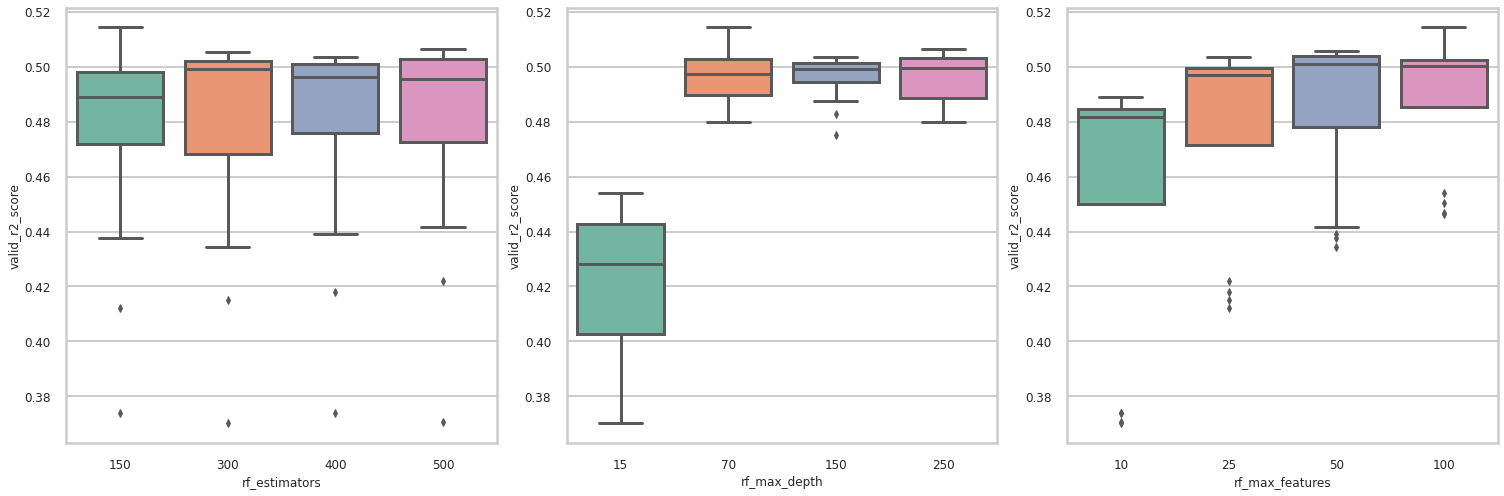

In [22]:
fig, ax = plt.subplots(1,3,figsize=(21,7))
sns.boxplot(data=perf_df, x="rf_estimators", y="valid_r2_score", ax=ax[0])
sns.boxplot(data=perf_df, x="rf_max_depth", y="valid_r2_score", ax=ax[1])
sns.boxplot(data=perf_df, x="rf_max_features", y="valid_r2_score", ax=ax[2])
fig.tight_layout()